<a href="https://colab.research.google.com/github/AlessandroVacca/ANNDL-Challenges/blob/main/C1/colab/NotebookV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Ellipse

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA

2.13.0


In [5]:
gpu_available = tf.test.is_gpu_available()
is_cuda_gpu_available = tf.test.is_gpu_available(cuda_only=True)
is_cuda_gpu_min_3 = tf.test.is_gpu_available(True, (3,0))
print("gpu_available: ", gpu_available, "is_cuda_gpu_available: ", is_cuda_gpu_available)

gpu_available:  True is_cuda_gpu_available:  True


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
read_data_without_outliers_failed = !cp /gdrive/MyDrive/ANN-HOMEWORK/data_without_outliers.npz /content/data_without_outliers.npz
read_data_without_outliers_failed = len(read_data_without_outliers_failed) > 0
if read_data_without_outliers_failed:
  print("Cleaned data without memes not found")
  %cp /gdrive/MyDrive/ANN-HOMEWORK/public_data.zip /content/public_data.zip
  !unzip public_data.zip

## OUTLIER CHECK AND REMOVAL

In [ ]:
plot = False
if read_data_without_outliers_failed:
  # load dataset
  train_data = np.load("public_data.npz", allow_pickle=True)
  images = train_data["data"]
  labels = train_data["labels"]

  mobile = tfk.applications.MobileNetV2(
      input_shape=(96, 96, 3),
      include_top=False,
      weights="imagenet",
      pooling='avg',
  )
  # mobile.summary()

  # extract features using the imagenet backbone
  dataset_features = mobile.predict(preprocess_input(images),batch_size=32,verbose=0)

  ##################
  # RUN PCA
  ##################
  # Assuming 'dataset_features' is your feature matrix (samples x features)
  # Assuming 'images' is your image dataset as a NumPy array

  # Perform PCA on the feature data
  n_components = 2  # Adjust the number of components as needed
  pca = PCA(n_components=n_components)
  pca_results = pca.fit_transform(dataset_features)

  # Calculate the covariance matrix of the normal data
  cov_matrix = np.cov(pca_results, rowvar=False)

  # Calculate the inverse of the covariance matrix
  inv_cov_matrix = np.linalg.inv(cov_matrix)

  # Calculate the mean of the normal data
  mean = np.mean(pca_results, axis=0)

  # Calculate the Mahalanobis distances
  distances = []
  for i in range(pca_results.shape[0]):
      diff = pca_results[i] - mean
      mahalanobis_dist = np.sqrt(np.dot(np.dot(diff, inv_cov_matrix), diff))
      distances.append(mahalanobis_dist)

  # Define a threshold for identifying outliers
  threshold = np.percentile(distances, 96.24)  # Adjust the percentile as needed
  outlier_indices = np.where(distances > threshold)[0]

  ############
  # COMPUTE NEW DATASET and SAVE IT
  ############
  # Assuming 'images' is your image dataset as a NumPy array
  images_without_outliers = np.delete(images, outlier_indices, axis=0)

  # Update 'dataset_features' accordingly
  labels_without_outlier = np.delete(labels, outlier_indices, axis=0)

  # Save the arrays to an NPZ file
  np.savez("data_without_outliers.npz", data=images_without_outliers, labels=labels_without_outlier)
  %cp /content/data_without_outliers.npz /gdrive/MyDrive/ANN-HOMEWORK/data_without_outliers.npz

  #############
  # PLOT
  #############
  if plot:
    # Define a function to overlay images on the plot
    def plot_images_on_pca(pca_results, images, ax, outlier_indices, zoom=0.25):
        for i, (x, y) in enumerate(pca_results):
            img = OffsetImage(images[i], zoom=zoom)
            ab = AnnotationBbox(img, (x, y), frameon=False, pad=0)
            ax.add_artist(ab)
    # Create a scatter plot to visualize the PCA results
    plt.figure(figsize=(8, 6))
    ax = plt.gca()

    # Overlay images on the plot
    plot_images_on_pca(pca_results, images, ax, outlier_indices)

    # Highlight outliers
    plt.scatter(
        pca_results[outlier_indices, 0],
        pca_results[outlier_indices, 1],
        c="red",
        s=300,
        marker="x",
    )

    # Plot the covariance ellipse
    ellipse = Ellipse(xy=mean, width=5 * np.sqrt(cov_matrix[0, 0]), height=5 * np.sqrt(cov_matrix[1, 1]),
                      edgecolor='g', facecolor='none', linestyle='--', label="Covariance Ellipse")
    ax.add_patch(ellipse)

    plt.title("PCA Outlier Detection with Images (Mahalanobis Distance)")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.show()
    print("Found", len(outlier_indices), "outliers")


## visualize data and split

In [8]:
train_data = np.load("data_without_outliers.npz", allow_pickle=True)
list(train_data.keys())

['data', 'labels']

In [9]:
images = train_data["data"]
images = images
labels = train_data["labels"]


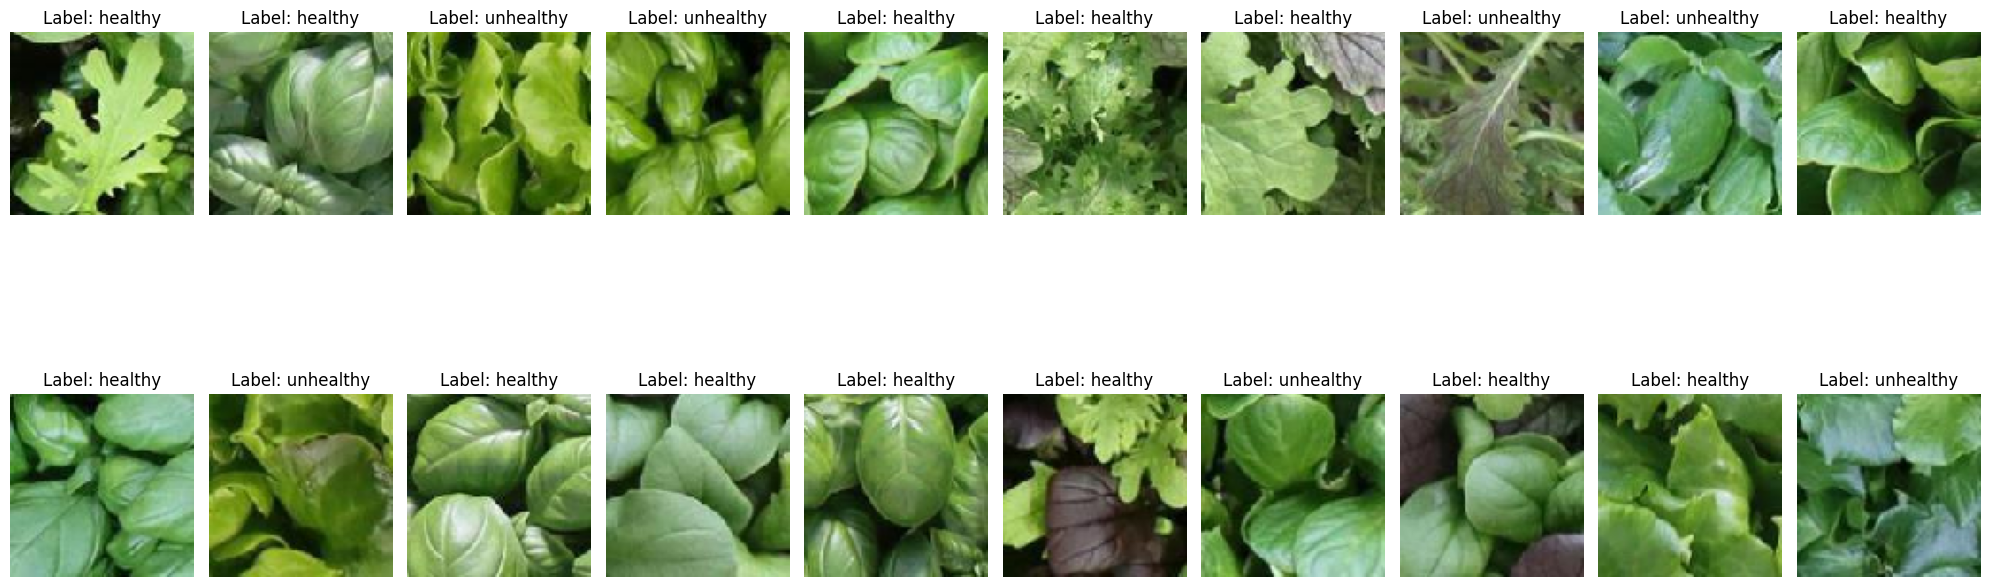

In [10]:
# Number of images to display
num_img = 20

# Create subplots for displaying items
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(np.clip(images[i], 0, 255))  # Display clipped item images
    ax.axis('off')
    ax.set_title("Label: " + str(labels[i]))
plt.tight_layout()
plt.show()

### Train Test Val split

In [11]:
# Find unique values and their counts in the 'quality' column of the 'wine' DataFrame
unique, count = np.unique(labels, return_counts=True)
print(unique)
count

['healthy' 'unhealthy']


array([3101, 1903])

In [12]:
# Define replacement values and labels
replacement_dict = {'healthy': 0, 'unhealthy': 1}

# Create a custom replacement function
replace_func = np.vectorize(lambda x: replacement_dict.get(x, x))

# Replace values in the NumPy array
labels = replace_func(labels)
categorical_labels = tf.keras.utils.to_categorical(labels, num_classes=2)

In [13]:
# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(images, categorical_labels, random_state=seed, test_size=60, stratify=np.argmax(categorical_labels,axis=1))

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=60, stratify=np.argmax(y_train_val,axis=1))

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (4884, 96, 96, 3), y_train shape: (4884, 2)
X_val shape: (60, 96, 96, 3), y_val shape: (60, 2)
X_test shape: (60, 96, 96, 3), y_test shape: (60, 2)


In [14]:
class_weights = compute_class_weight('balanced', classes=[0,1], y=np.argmax(y_train, axis=1))

class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

{0: 0.8067393458870169, 1: 1.3150242326332795}


## TRANSFER LEARNING

In [47]:
# Create MobileNetV2 model with specified settings
mobile = tfk.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)

# Display the model architecture with input shapes
# tfk.utils.plot_model(mobile, show_shapes=True)

mobile.trainable = False

In [75]:
# Create an input layer with shape (96, 96, 3)
inputs = tfk.Input(shape=(96, 96, 3))


preprocessing = tf.keras.Sequential([
        # tfkl.RandomBrightness(0.05, value_range=(0,255)),
        tfkl.RandomTranslation(0.35,0.35),
        tfkl.RandomFlip(),
        tfkl.RandomRotation(0.35),
        tfkl.RandomZoom(0.3),
        # tfkl.RandomContrast(0.05),
    ], name='preprocessing')(inputs)

# Connect MobileNetV2 to the input
x = mobile(preprocessing)

# Connect MobileNetV2 to the input
# x = mobile(inputs)
# Add a Dense layer with 2 units and softmax activation as the classifier
outputs = tfkl.Dense(2, activation='softmax')(x)

# Create a Model connecting input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

# Display model summary
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 dense_4 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [76]:
# Train the model
tl_history = tl_model.fit(
    x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 32,
    epochs = 20,
    class_weight=class_weight_dict,
    validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
                 tfk.callbacks.ModelCheckpoint("best_model_weights.h5",
                             monitor='val_accuracy',  # Monitor validation loss
                             save_best_only=True,  # Save only the best weights
                             mode='max',  # 'min' for loss, 'max' for accuracy, etc.
                             verbose=1,
                             restore_best_weights=True)  # Restore best weights at the end of training
                 ]
).history

Epoch 1/20
152/153 [============================>.] - ETA: 0s - loss: 0.8374 - accuracy: 0.5280
Epoch 1: val_accuracy improved from -inf to 0.66667, saving model to best_model_weights.h5
153/153 [==============================] - 8s 29ms/step - loss: 0.8368 - accuracy: 0.5283 - val_loss: 0.7115 - val_accuracy: 0.6667
Epoch 2/20
152/153 [============================>.] - ETA: 0s - loss: 0.7055 - accuracy: 0.5968
Epoch 2: val_accuracy improved from 0.66667 to 0.68333, saving model to best_model_weights.h5
153/153 [==============================] - 4s 25ms/step - loss: 0.7050 - accuracy: 0.5968 - val_loss: 0.6163 - val_accuracy: 0.6833
Epoch 3/20
153/153 [==============================] - ETA: 0s - loss: 0.6655 - accuracy: 0.6278
Epoch 3: val_accuracy did not improve from 0.68333
153/153 [==============================] - 4s 23ms/step - loss: 0.6655 - accuracy: 0.6278 - val_loss: 0.5724 - val_accuracy: 0.6667
Epoch 4/20
152/153 [============================>.] - ETA: 0s - loss: 0.6339 - a

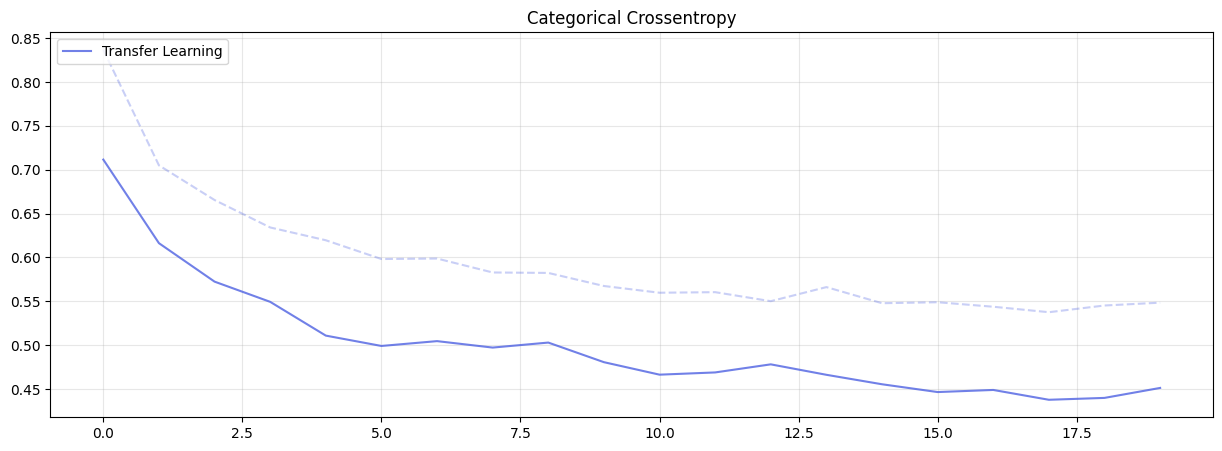

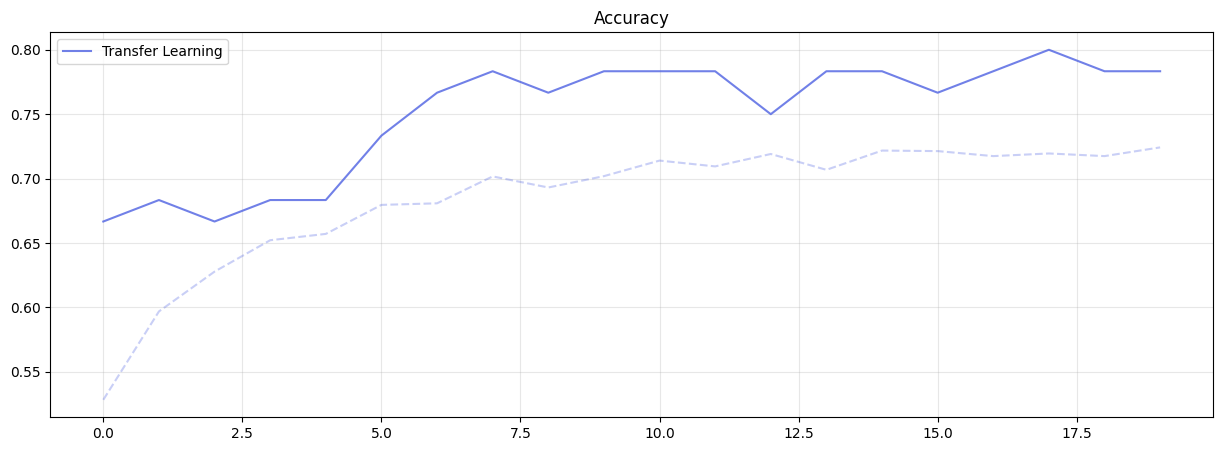

In [77]:
# Plot the re-trained and the transfer learning MobileNetV2 training histories
plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [78]:
tl_model.save("tl_model.h5")
del tl_model
tl_model = tfk.models.load_model('tl_model.h5')


## FINE TUNING

In [79]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('tl_model.h5')
ft_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 dense_4 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [80]:
# Set all MobileNetV2 layers as trainable
ft_model.get_layer('mobilenetv2_1.00_96').trainable = True
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers):
   print(i, layer.name, layer.trainable)

0 input_5 True
1 Conv1 True
2 bn_Conv1 True
3 Conv1_relu True
4 expanded_conv_depthwise True
5 expanded_conv_depthwise_BN True
6 expanded_conv_depthwise_relu True
7 expanded_conv_project True
8 expanded_conv_project_BN True
9 block_1_expand True
10 block_1_expand_BN True
11 block_1_expand_relu True
12 block_1_pad True
13 block_1_depthwise True
14 block_1_depthwise_BN True
15 block_1_depthwise_relu True
16 block_1_project True
17 block_1_project_BN True
18 block_2_expand True
19 block_2_expand_BN True
20 block_2_expand_relu True
21 block_2_depthwise True
22 block_2_depthwise_BN True
23 block_2_depthwise_relu True
24 block_2_project True
25 block_2_project_BN True
26 block_2_add True
27 block_3_expand True
28 block_3_expand_BN True
29 block_3_expand_relu True
30 block_3_pad True
31 block_3_depthwise True
32 block_3_depthwise_BN True
33 block_3_depthwise_relu True
34 block_3_project True
35 block_3_project_BN True
36 block_4_expand True
37 block_4_expand_BN True
38 block_4_expand_relu Tru

In [81]:
# Freeze first N layers, e.g., until the 133rd one
N = 133
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_5 False
1 Conv1 False
2 bn_Conv1 False
3 Conv1_relu False
4 expanded_conv_depthwise False
5 expanded_conv_depthwise_BN False
6 expanded_conv_depthwise_relu False
7 expanded_conv_project False
8 expanded_conv_project_BN False
9 block_1_expand False
10 block_1_expand_BN False
11 block_1_expand_relu False
12 block_1_pad False
13 block_1_depthwise False
14 block_1_depthwise_BN False
15 block_1_depthwise_relu False
16 block_1_project False
17 block_1_project_BN False
18 block_2_expand False
19 block_2_expand_BN False
20 block_2_expand_relu False
21 block_2_depthwise False
22 block_2_depthwise_BN False
23 block_2_depthwise_relu False
24 block_2_project False
25 block_2_project_BN False
26 block_2_add False
27 block_3_expand False
28 block_3_expand_BN False
29 block_3_expand_relu False
30 block_3_pad False
31 block_3_depthwise False
32 block_3_depthwise_BN False
33 block_3_depthwise_relu False
34 block_3_project False
35 block_3_project_BN False
36 block_4_expand False
37 block_4_expa

In [82]:
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')

In [83]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 32,
    epochs = 10,
    validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
                 tfk.callbacks.ModelCheckpoint("best_model_weights.h5",
                             monitor='val_accuracy',  # Monitor validation loss
                             save_best_only=True,  # Save only the best weights
                             mode='max',  # 'min' for loss, 'max' for accuracy, etc.
                             verbose=1,
                             restore_best_weights=True)  # Restore best weights at the end of training
]
).history

Epoch 1/10
152/153 [============================>.] - ETA: 0s - loss: 0.6237 - accuracy: 0.6655
Epoch 1: val_accuracy improved from -inf to 0.86667, saving model to best_model_weights.h5
153/153 [==============================] - 11s 36ms/step - loss: 0.6245 - accuracy: 0.6650 - val_loss: 0.4244 - val_accuracy: 0.8667
Epoch 2/10
152/153 [============================>.] - ETA: 0s - loss: 0.5878 - accuracy: 0.6933
Epoch 2: val_accuracy did not improve from 0.86667
153/153 [==============================] - 4s 27ms/step - loss: 0.5872 - accuracy: 0.6939 - val_loss: 0.4249 - val_accuracy: 0.8667
Epoch 3/10
151/153 [============================>.] - ETA: 0s - loss: 0.5613 - accuracy: 0.7196
Epoch 3: val_accuracy improved from 0.86667 to 0.90000, saving model to best_model_weights.h5
153/153 [==============================] - 4s 29ms/step - loss: 0.5613 - accuracy: 0.7193 - val_loss: 0.4183 - val_accuracy: 0.9000
Epoch 4/10
152/153 [============================>.] - ETA: 0s - loss: 0.5515 - 

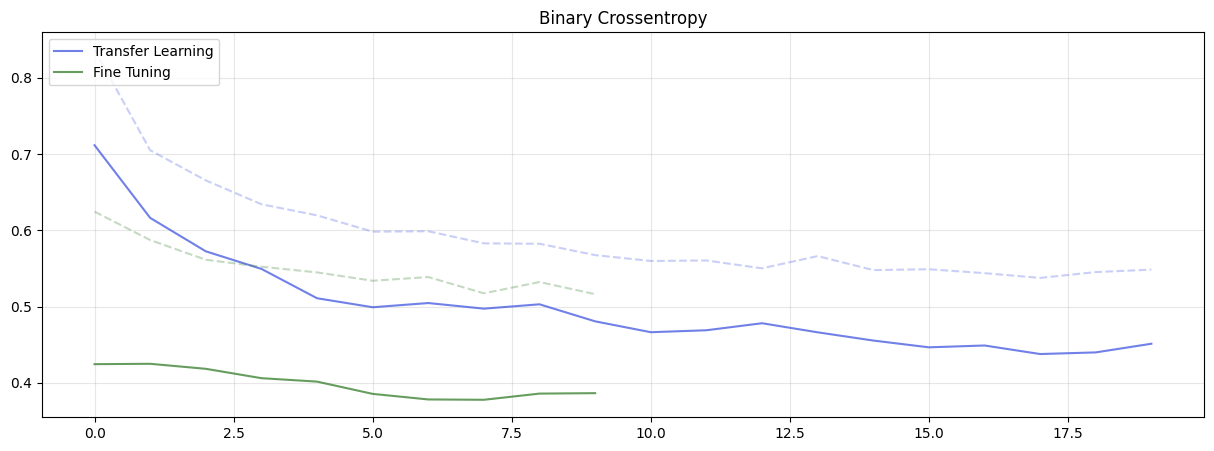

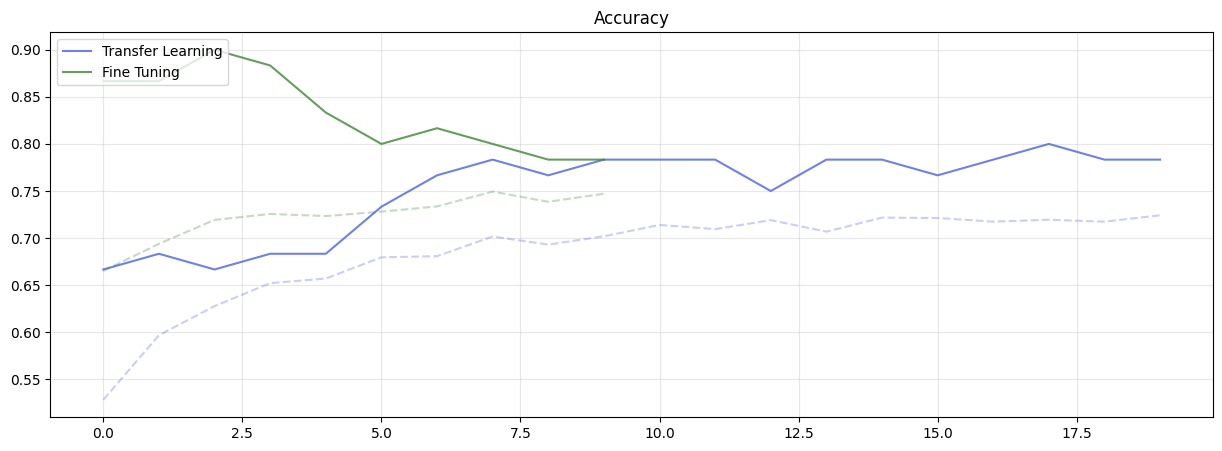

In [84]:
# Plot the re-trained, the transfer learning and the fine-tuned MobileNetV2 training histories
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['loss'], alpha=.3, color='#408537', linestyle='--')
plt.plot(ft_history['val_loss'], label='Fine Tuning', alpha=.8, color='#408537')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['accuracy'], alpha=.3, color='#408537', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=.8, color='#408537')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [85]:
# Evaluate the model on the test set
test_accuracy = ft_model.evaluate(preprocess_input(X_test*255),y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

Test set accuracy 0.7167


In [86]:
# Save the best model
ft_model.save('FineTuningModel.h5')
del ft_model